In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [222]:
def random_prob(*n) -> np.ndarray:
    p = np.random.rand(*n)/n[-1]**2 + 1/n[-1]
    p /= p.sum(axis=-1, keepdims=True)
    return p

In [223]:
x = random_prob(3, 3)
assert np.allclose(x.sum(axis=-1), np.array([1]*3))
x

array([[0.31153293, 0.33117343, 0.35729364],
       [0.33988574, 0.33538473, 0.32472953],
       [0.29929807, 0.33500608, 0.36569585]])

In [225]:
x = random_prob(3)
assert np.allclose(x.sum(axis=-1), 1.0)
x

array([0.30205218, 0.32757237, 0.37037545])

In [226]:
from typing import List
from itertools import product
    
    
class HMM:
    def __init__(self, Q: List, O: List, A = None, B = None, pi = None):
        self.Q = Q
        self.O = O
        self.q_idx = {q: i for i, q in enumerate(Q)}
        self.o_idx = {o: i for i, o in enumerate(O)}
        
        n = len(self.Q)
        m = len(self.O)
        
        self.A = A if A is not None else random_prob(n, n)
        self.B = B if B is not None else random_prob(n, m)
        self.pi = pi if pi is not None else random_prob(n)
    
    def __repr__(self):
        pi = pd.DataFrame(self.pi, index=self.Q, columns=['init_p'])
        A = pd.DataFrame(self.A, index=self.Q, columns=self.Q)
        B = pd.DataFrame(self.B, index=self.Q, columns=self.O)
        return f"A:\n{A}\n\nB:\n{B}\n\npi:\n{pi}"
    
    def single_prob(self, chain, obs):
        p = self.pi[chain[0]] * self.B[chain[0], obs[0]]
        for p_s, s, o in zip(chain, chain[1:], obs[1:]):
            p *= self.A[p_s, s]*self.B[s, o]
        return p
        
    def naive_prob(self, obs: List):
        obs_ = [self.o_idx[o] for o in obs]
        sz = len(obs_)
        states = list(range(len(self.Q))) 
        iters =  (states,) * sz
        all_chains = product(*iters)
        return sum(self.single_prob(chain, obs_) for chain in all_chains)
    
    def _alphas(self, obs: List):        
        a = np.zeros((len(obs), len(self.Q)))
        a[0, :] = (self.pi * self.B[:, obs[0]]).T
        for t in range(1, len(obs)):
            a[t, :] = (a[t-1, :] @ self.A) * self.B[:, obs[t]].T
        return a
        
    def alphas(self, obs: List): 
        obs = [self.o_idx[o] for o in obs]
        return self._alphas(obs)
        
    def _prob(self, obs: List):
        a = self._alphas(obs)
        return a[-1].sum()
    
    def prob(self, obs: List):
        obs = [self.o_idx[o] for o in obs]
        return self._prob(obs)

    def run(self, length: int) -> (List, List):
        s_history = [0] * (length + 1)
        o_history = [0] * (length + 1)
        
        prb = self.pi
        obs = prb @ self.B
        s_history[0] = np.random.choice(self.Q, p=prb.flatten())
        o_history[0] = np.random.choice(self.O, p=obs.flatten())
        
        for t in range(1, length + 1):
            prb = prb @ self.A
            obs = prb @ self.B
            s_history[t] = np.random.choice(self.Q, p=prb.flatten())
            o_history[t] = np.random.choice(self.O, p=obs.flatten())
        
        return o_history, s_history
    
    def _betas(self, obs: List) -> np.ndarray:
        betas = np.zeros((len(obs), len(self.Q)))
        betas[-1, :] = 1
        
        for t in range(len(obs) - 2, -1, -1):
            betas[t, :] = (self.A @ \
                           (self.B[:, obs[t+1]] * betas[t+1, :].T)).T
        return betas

    def betas(self, obs: List) -> np.ndarray:
        obs = [self.o_idx[o] for o in obs]
        return self._betas(obs)
    
    def find_hiddens(self, obs: List) -> List:
        obs = [self.o_idx[o] for o in obs]
        a = self._alphas(obs)
        b = self._betas(obs)
        maxargs = (a * b).argmax(axis=1)
        return list(map(lambda x: self.Q[x], maxargs))
    
    def _digammas(self, obs: List):
        L, N = len(obs), len(self.Q)
        digammas = np.zeros((L - 1, N, N))

        a = self._alphas(obs)
        b = self._betas(obs)
        p = self._prob(obs)
        gamma = a * b / p 
        
        for t in range(L - 1):
            p1 = (a[t, :].reshape(-1, 1) * self.A)
            p2 = self.B[:, obs[t + 1]] * b[t + 1, :].T
            digammas[t, :, :] = p1 * p2 / p
        return digammas, gamma, p    

    def digammas(self, obs: List):
        obs = [self.o_idx[o] for o in obs]
        return self._digammas(obs)
    
    def _update(self, obs: list) -> float:
        digamma, gamma, p = self._digammas(obs)

        L = len(obs)
        capture = np.zeros((L, len(self.Q), len(self.O)))
        for t in range(L):
            capture[t, :, obs[t]] = 1.0

        self.pi = gamma[0]
        self.A = digamma.sum(axis=0) / gamma[:-1].sum(axis=0).reshape(-1, 1)
        self.B = (capture * gamma[:, :, np.newaxis]).sum(axis=0) / gamma.sum(axis=0).reshape(-1, 1)
        
        return p
    
    def train(self, obs: list, epochs: int, tol=None):
        obs = [self.o_idx[o] for o in obs]
        
        score_init = 0
        score_history = (epochs + 1) * [0]
        early_stopping = isinstance(tol, (int, float))

        for epoch in range(1, epochs + 1):
            score = self._update(obs)
            print("Training... epoch = {} out of {}, score = {}.".format(epoch, epochs, score))
            if early_stopping and abs(score_init - score) / score < tol:
                print("Early stopping.")
                break
            score_init = score
            score_history[epoch] = score
        return score_history
                
    

In [227]:
hmm = HMM(list('abcd'), list('xyz'))
hmm

A:
          a         b         c         d
a  0.237961  0.238433  0.259172  0.264434
b  0.237227  0.239344  0.268583  0.254847
c  0.247688  0.245775  0.259815  0.246722
d  0.272589  0.226163  0.245319  0.255929

B:
          x         y         z
a  0.382308  0.317669  0.300024
b  0.298334  0.361076  0.340590
c  0.353483  0.351122  0.295395
d  0.320848  0.313829  0.365323

pi:
     init_p
a  0.269033
b  0.248035
c  0.227243
d  0.255689

In [228]:
A  = np.array([[0.7, 0.3], 
               [0.4, 0.6]])
B  = np.array([[0.1, 0.4, 0.5],
               [0.7, 0.2, 0.1]])
pi = np.array([0.6, 0.4])

hmm = HMM(['1H', '2C'], ['1S', '2M', '3L'], A, B, pi)
hmm

A:
     1H   2C
1H  0.7  0.3
2C  0.4  0.6

B:
     1S   2M   3L
1H  0.1  0.4  0.5
2C  0.7  0.2  0.1

pi:
    init_p
1H     0.6
2C     0.4

In [229]:
obs = ['1S', '2M', '3L', '2M', '1S']

In [230]:
hmm.naive_prob(obs)

0.0034819999999999994

In [231]:
hmm.prob(obs)

0.0034820000000000003

In [232]:
observation_hist, states_hist = hmm.run(100)  # length = 100
stats = pd.DataFrame({
    'observations': observation_hist,
    'states': states_hist})
stats

,observations,states
0,2M,2C
1,2M,2C
2,2M,1H
3,2M,2C
4,2M,1H
...,...,...
96,1S,1H
97,1S,1H
98,3L,2C
99,3L,1H


<IPython.core.display.Javascript object>


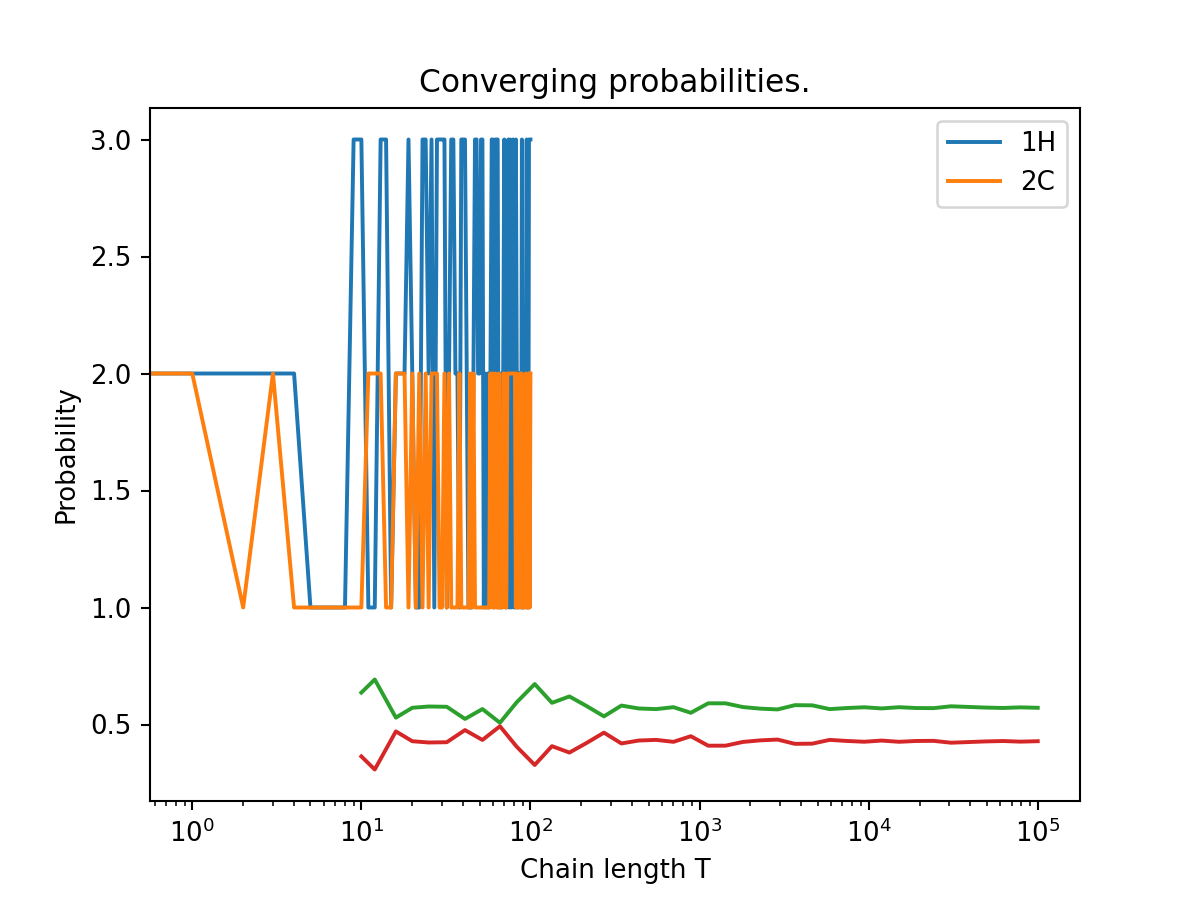

<AxesSubplot:>

In [233]:
stats.applymap(lambda x: int(x[0])).plot()

In [234]:
stats = {}
for length in np.logspace(1, 5, 40).astype(int):
    print(f"Current len {length}")
    observation_hist, states_hist = hmm.run(length)
    stats[length] = pd.DataFrame({
        'observations': observation_hist,
        'states': states_hist}).applymap(lambda x: int(x[0]))

S = np.array(list(map(lambda x: 
        x['states'].value_counts().to_numpy() / len(x), stats.values())))

Current len 10
Current len 12
Current len 16
Current len 20
Current len 25
Current len 32
Current len 41
Current len 52
Current len 66
Current len 83
Current len 106
Current len 134
Current len 170
Current len 215
Current len 272
Current len 345
Current len 437
Current len 554
Current len 701
Current len 888
Current len 1125
Current len 1425
Current len 1804
Current len 2285
Current len 2894
Current len 3665
Current len 4641
Current len 5878
Current len 7443
Current len 9426
Current len 11937
Current len 15117
Current len 19144
Current len 24244
Current len 30702
Current len 38881
Current len 49238
Current len 62355
Current len 78965
Current len 100000


In [235]:
plt.semilogx(np.logspace(1, 5, 40).astype(int), S)
plt.xlabel('Chain length T')
plt.ylabel('Probability')
plt.title('Converging probabilities.')
plt.legend(['1H', '2C'])
plt.show()

In [236]:
np.random.seed(42)

obs, latents = hmm.run(5)
obs, latents

(['3L', '2M', '1S', '3L', '3L', '3L'], ['1H', '2C', '1H', '1H', '2C', '1H'])

In [237]:
likely_sequence = hmm.find_hiddens(obs)

In [238]:
likely_sequence

['1H', '1H', '2C', '1H', '1H', '1H']

In [239]:
np.random.seed(42)

observations = ['3L', '2M', '1S', '3L', '3L', '3L']
hmm = HMM(['1H', '2C'], ['1S', '2M', '3L'])
hmm

A:
          1H        2C
1H  0.445902  0.554098
2C  0.512506  0.487494

B:
          1S        2M        3L
1H  0.336818  0.336816  0.326366
2C  0.345955  0.322237  0.331808

pi:
      init_p
1H  0.404887
2C  0.595113

In [240]:
hmm.train(observations, 25)

Training... epoch = 1 out of 25, score = 0.0013226387329490481.
Training... epoch = 2 out of 25, score = 0.005506353622667201.
Training... epoch = 3 out of 25, score = 0.005525930863902368.
Training... epoch = 4 out of 25, score = 0.005558516627620826.
Training... epoch = 5 out of 25, score = 0.0056153860299638265.
Training... epoch = 6 out of 25, score = 0.0057144634397034485.
Training... epoch = 7 out of 25, score = 0.005882771688739361.
Training... epoch = 8 out of 25, score = 0.006154104047118436.
Training... epoch = 9 out of 25, score = 0.006552016952675431.
Training... epoch = 10 out of 25, score = 0.007053306093401579.
Training... epoch = 11 out of 25, score = 0.007569344191957283.
Training... epoch = 12 out of 25, score = 0.008003524261484754.
Training... epoch = 13 out of 25, score = 0.008326158632886948.
Training... epoch = 14 out of 25, score = 0.0085652868029075.
Training... epoch = 15 out of 25, score = 0.008758613096861097.
Training... epoch = 16 out of 25, score = 0.0089

[0,
 0.0013226387329490481,
 0.005506353622667201,
 0.005525930863902368,
 0.005558516627620826,
 0.0056153860299638265,
 0.0057144634397034485,
 0.005882771688739361,
 0.006154104047118436,
 0.006552016952675431,
 0.007053306093401579,
 0.007569344191957283,
 0.008003524261484754,
 0.008326158632886948,
 0.0085652868029075,
 0.008758613096861097,
 0.008932966557952485,
 0.009106732299321373,
 0.009298722624244905,
 0.009540918537251912,
 0.009901404563918585,
 0.010529906315417514,
 0.011725130768897692,
 0.013871766026969446,
 0.01678790171873935,
 0.019239031373317447]

In [242]:
hmm

A:
          1H        2C
1H  0.050615  0.949385
2C  0.989089  0.010911

B:
          1S            2M        3L
1H  0.000613  3.356568e-01  0.663730
2C  0.330437  5.156817e-18  0.669563

pi:
          init_p
1H  1.068552e-10
2C  1.000000e+00

In [243]:
RUNS = 100000
T = 5

chains = RUNS * [0]
for i in range(len(chains)):
    chain = hmm.run(T)[0]
    chains[i] = '-'.join(chain)

In [244]:
chains[0]

'1S-2M-3L-2M-1S-3L'

In [245]:
df = pd.DataFrame(pd.Series(chains).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
df = pd.merge(df, df['chain'].str.split('-', expand=True), left_index=True, right_index=True)

In [246]:
df.head()

,chain,counts,0,1,2,3,4,5
0,3L-3L-3L-3L-3L-3L,8905,3L,3L,3L,3L,3L,3L
1,3L-2M-3L-3L-3L-3L,4413,3L,2M,3L,3L,3L,3L
2,1S-3L-3L-3L-3L-3L,4275,1S,3L,3L,3L,3L,3L
3,3L-3L-3L-2M-3L-3L,4103,3L,3L,3L,2M,3L,3L
4,3L-3L-1S-3L-3L-3L,4058,3L,3L,1S,3L,3L,3L


In [247]:
s = []
for i in range(T + 1):
    s.append(df.apply(lambda x: x[i] == observations[i], axis=1))

df['matched'] = pd.concat(s, axis=1).sum(axis=1)
df['counts'] = df['counts'] / RUNS * 100
df = df.drop(columns=['chain'])
df.head(30)

,counts,0,1,2,3,4,5,matched
0,8.905,3L,3L,3L,3L,3L,3L,4
1,4.413,3L,2M,3L,3L,3L,3L,5
2,4.275,1S,3L,3L,3L,3L,3L,3
3,4.103,3L,3L,3L,2M,3L,3L,3
4,4.058,3L,3L,1S,3L,3L,3L,5
5,3.965,3L,3L,3L,3L,3L,2M,3
6,3.893,3L,3L,3L,3L,1S,3L,3
7,2.088,1S,2M,3L,3L,3L,3L,4
8,2.075,3L,2M,3L,2M,3L,3L,4
9,2.064,1S,3L,1S,3L,3L,3L,4


In [248]:
df.tail(10)

,counts,0,1,2,3,4,5,matched
344,0.001,3L,1S,3L,1S,3L,2M,2
345,0.001,1S,1S,3L,3L,2M,3L,2
346,0.001,3L,2M,2M,1S,3L,2M,3
347,0.001,1S,1S,1S,2M,1S,1S,1
348,0.001,3L,1S,1S,1S,3L,2M,3
349,0.001,3L,2M,2M,2M,1S,1S,2
350,0.001,3L,1S,3L,3L,2M,3L,3
351,0.001,3L,2M,2M,3L,2M,2M,3
352,0.001,3L,1S,1S,1S,3L,3L,4
353,0.001,1S,1S,3L,2M,1S,1S,0


<IPython.core.display.Javascript object>


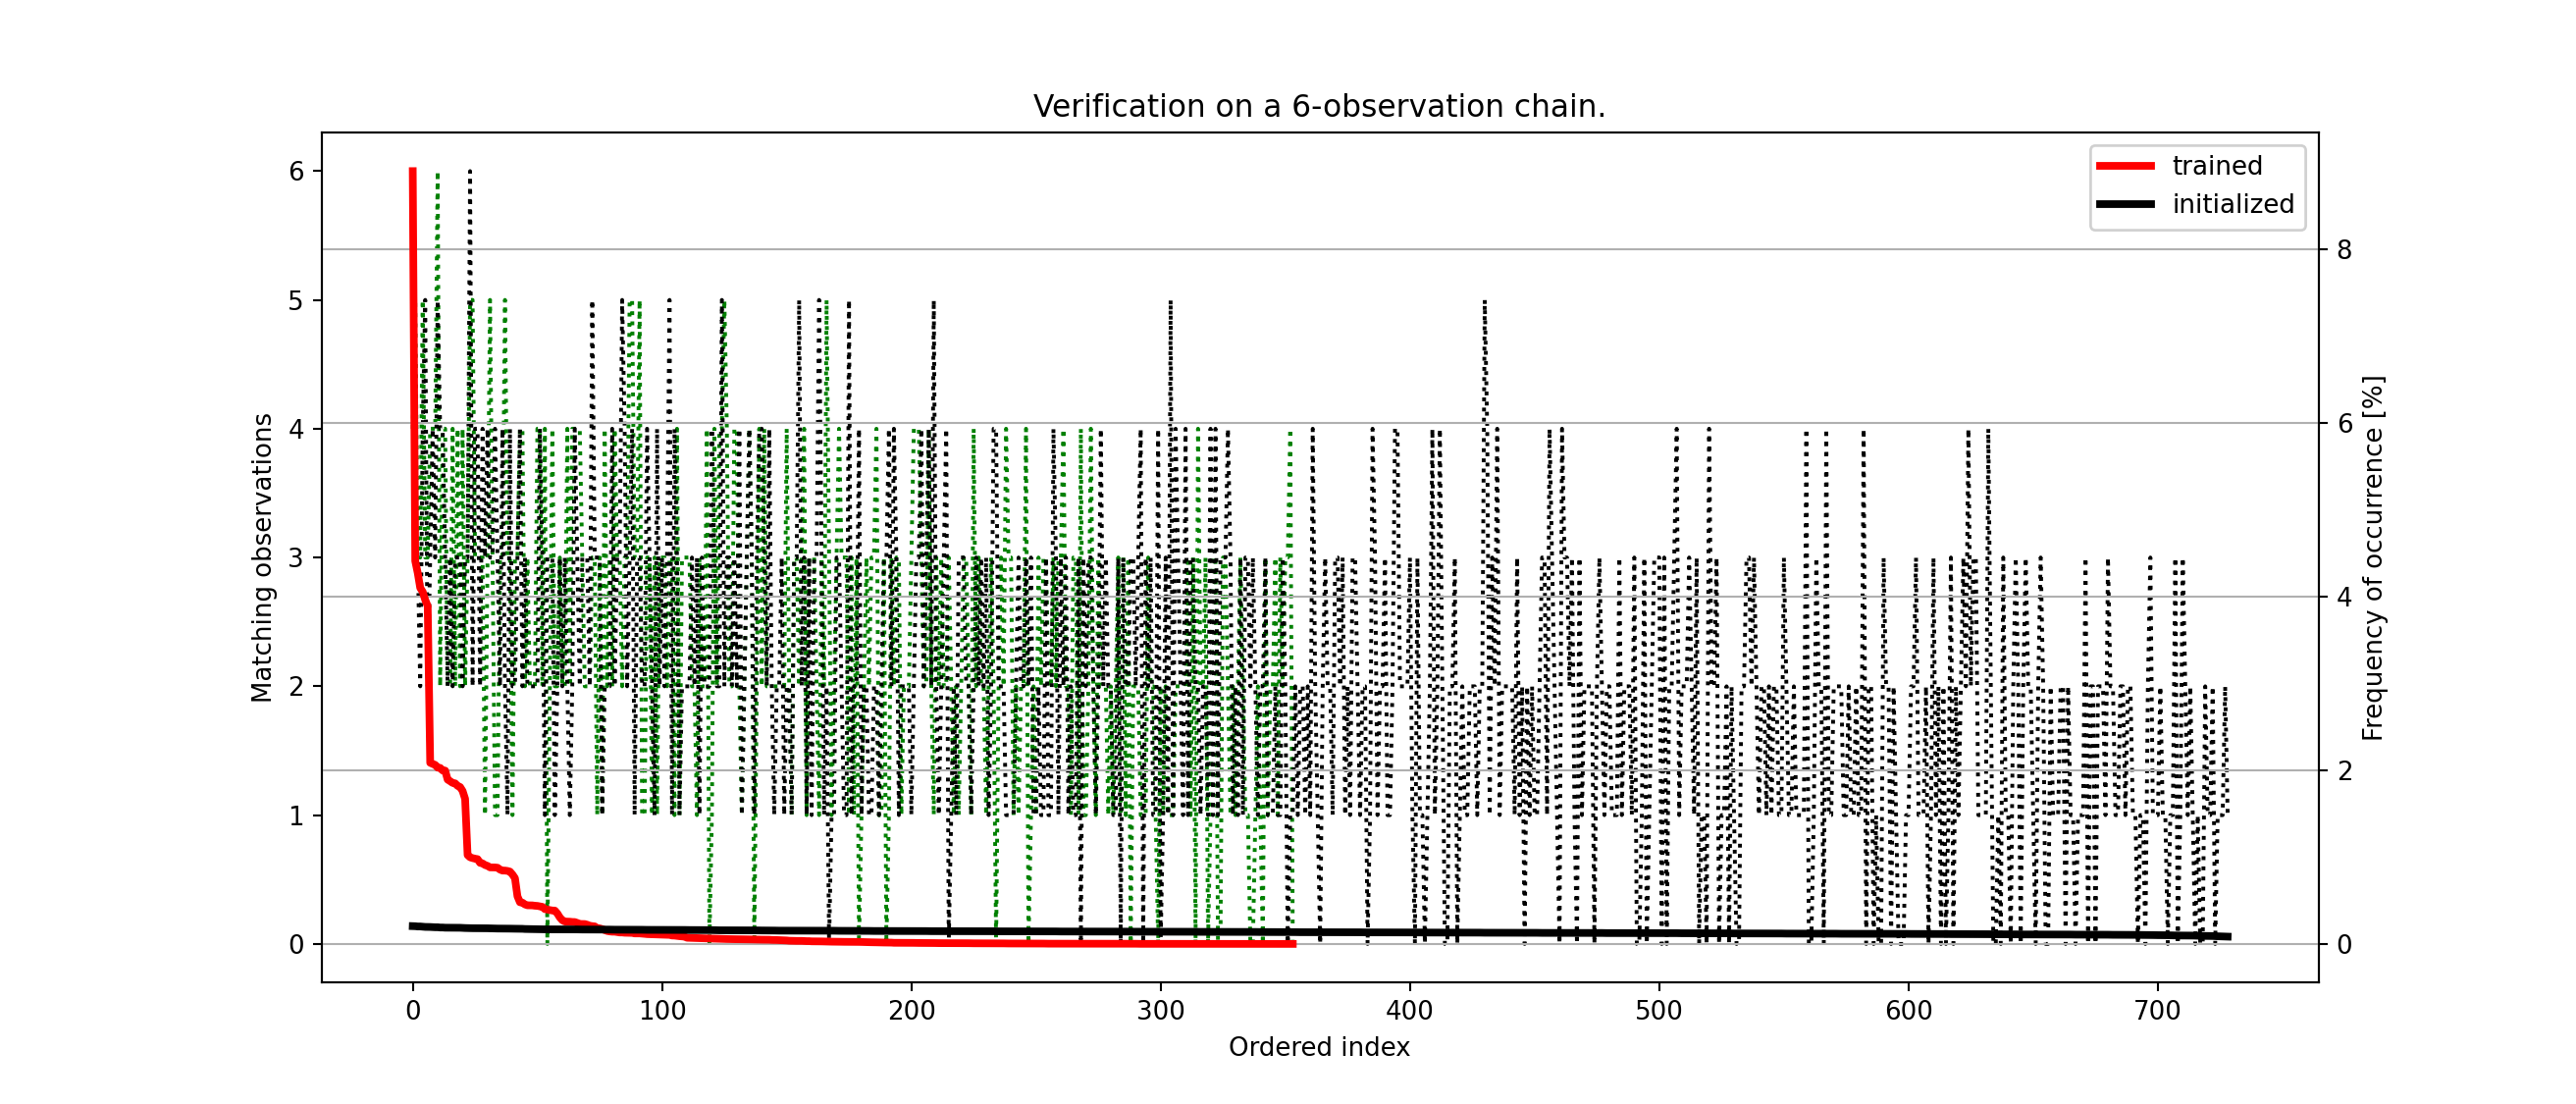

In [249]:
RUNS = 100000
T = 5
hmm2 = HMM(['1H', '2C'], ['1S', '2M', '3L'])

chains_rand = RUNS * [0]
for i in range(len(chains_rand)):
    chain_rand = hmm2.run(T)[0]
    chains_rand[i] = '-'.join(chain_rand)

df2 = pd.DataFrame(pd.Series(chains_rand).value_counts(), columns=['counts']).reset_index().rename(columns={'index': 'chain'})
df2 = pd.merge(df2, df2['chain'].str.split('-', expand=True), left_index=True, right_index=True)

s = []
for i in range(T + 1):
    s.append(df2.apply(lambda x: x[i] == observations[i], axis=1))

df2['matched'] = pd.concat(s, axis=1).sum(axis=1)
df2['counts'] = df2['counts'] / RUNS * 100
df2 = df2.drop(columns=['chain'])

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(df['matched'], 'g:')
ax.plot(df2['matched'], 'k:')

ax.set_xlabel('Ordered index')
ax.set_ylabel('Matching observations')
ax.set_title('Verification on a 6-observation chain.')

ax2 = ax.twinx()
ax2.plot(df['counts'], 'r', lw=3)
ax2.plot(df2['counts'], 'k', lw=3)
ax2.set_ylabel('Frequency of occurrence [%]')

ax.legend(['trained', 'initialized'])
ax2.legend(['trained', 'initialized'])

plt.grid()
plt.show()